In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [27]:
class ParkingComplaintPredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.model = None
        self.feature_names = []
        
    def load_data(self, parking_file, complaint_file):
        """
        주차장 데이터와 민원 데이터 로드
        """
        self.parking_df = pd.read_csv(parking_file)
        self.complaint_df = pd.read_csv(complaint_file)

        self.complaint_df = self.complaint_df.sample(n=10000, random_state=self.random_state)
        self.complaint_df = self.complaint_df.reset_index(drop=True)
        
        print(f"주차장 데이터 로드: {len(self.parking_df)}개")
        print(f"민원 데이터 로드: {len(self.complaint_df)}개")
        
        # 컬럼명 출력 (확인용)
        print("\n주차장 데이터 컬럼:")
        print(self.parking_df.columns.tolist())
        print("\n민원 데이터 컬럼:")
        print(self.complaint_df.columns.tolist())
        
    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        하버사인 공식을 사용하여 두 지점 간의 거리를 미터 단위로 계산
        """
        # 지구 반지름 (미터)
        R = 6371000
        
        # 도를 라디안으로 변환
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
        
        # 위도와 경도 차이
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        # 하버사인 공식
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        
        # 거리 계산 (미터)
        distance = R * c
        
        return distance
        
    def calculate_complaints_within_radius(self, radius_m=500):
        """
        각 주차장 반경 내에서 '운영 시간 내' 민원 발생만 count (하버사인 공식 사용)
        """
        print(f"반경 {radius_m}m 내, 운영 시간 내 민원수 계산 중...")

        # 민원 데이터의 시각을 datetime으로 변환
        self.complaint_df['민원접수시간'] = pd.to_datetime(self.complaint_df['민원접수시간'], errors='coerce')
        self.complaint_df['weekday'] = self.complaint_df['민원접수시간'].dt.weekday   # 0:월~6:일
        self.complaint_df['hour'] = self.complaint_df['민원접수시간'].dt.hour

        complaint_counts = []

        for idx, parking in tqdm(self.parking_df.iterrows(), total=len(self.parking_df), desc="민원수 계산", unit="주차장"):
            parking_lat = parking['위도']
            parking_lon = parking['경도']

            # 요일별 운영 시작/종료 시각 (int)
            weekday_start = int(parking.get('평일시작', 0))
            weekday_end = int(parking.get('평일종료', 24))
            sat_start = int(parking.get('토요일시작', 0))
            sat_end = int(parking.get('토요일종료', 24))
            hol_start = int(parking.get('공휴일시작', 0))
            hol_end = int(parking.get('공휴일종료', 24))

            count = 0
            for _, complaint in self.complaint_df.iterrows():
                complaint_lat = complaint['위도']
                complaint_lon = complaint['경도']
                c_weekday = complaint['weekday']
                c_hour = complaint['hour']

                # 거리 계산
                distance = self.haversine_distance(
                    parking_lat, parking_lon, 
                    complaint_lat, complaint_lon
                )
                if distance > radius_m:
                    continue

                # 요일별 운영 시간 내인지 체크
                is_open = False
                if c_weekday <= 4: # 평일
                    if weekday_start <= c_hour < weekday_end:
                        is_open = True
                elif c_weekday == 5: # 토요일
                    if sat_start <= c_hour < sat_end:
                        is_open = True
                else: # 일요일/공휴일
                    if hol_start <= c_hour < hol_end:
                        is_open = True
                if is_open:
                    count += 1

            complaint_counts.append(count)

            if idx % 100 == 0:
                print(f"진행률: {idx+1}/{len(self.parking_df)}")

        self.parking_df['complaint_count'] = complaint_counts
        print(f"민원수 계산 완료. 평균 민원수: {np.mean(complaint_counts):.2f}")
        print(f"최대 민원수: {max(complaint_counts)}, 최소 민원수: {min(complaint_counts)}")

    def calculate_or_load_complaints(self, radius_m=500, save_file="parking_with_complaint_count.csv"):
        # 저장된 파일이 있으면 불러오기
        if os.path.exists(save_file):
            print(f"{save_file} 불러오는 중...")
            self.parking_df = pd.read_csv(save_file)
        else:
            self.calculate_complaints_within_radius(radius_m=radius_m)
            self.parking_df.to_csv(save_file, index=False)
            print(f"{save_file}로 저장 완료!")

    def preprocess_features(self):
        """
        주차장 특성 전처리
        """
        # 수치형 특성
        numeric_features = [
            '총주차면', '1시간요금',
            '평일운영시간', '토요일운영시간', '공휴일운영시간',
            '평일시작', '평일종료', '토요일시작', '토요일종료', 
            '공휴일시작', '공휴일종료'
        ]
        
        # 범주형 특성
        categorical_features = ['운영구분']
        
        # 유료/무료 정보를 숫자로 변환 (유료=1, 무료=0)
        fee_columns = ['평일유료', '토요일유료', '공휴일유료']
        for col in fee_columns:
            if col in self.parking_df.columns:
                self.parking_df[col + '_encoded'] = (self.parking_df[col] == '유료').astype(int)
        
        
        # 파생 변수 생성
        if '총주차면' in self.parking_df.columns and '1시간요금' in self.parking_df.columns:
            self.parking_df['수익잠재력'] = self.parking_df['총주차면'] * self.parking_df['1시간요금']
        
        # 평균 운영시간 계산
        time_cols = ['평일운영시간', '토요일운영시간', '공휴일운영시간']
        available_time_cols = [col for col in time_cols if col in self.parking_df.columns]
        if available_time_cols:
            self.parking_df['평균운영시간'] = self.parking_df[available_time_cols].mean(axis=1)
        
        # 범주형 변수 인코딩
        for col in categorical_features:
            if col in self.parking_df.columns:
                le = LabelEncoder()
                self.parking_df[col + '_encoded'] = le.fit_transform(self.parking_df[col].astype(str))
                self.label_encoders[col] = le
        
        # 특성 선택
        feature_columns = []
        
        # 수치형 특성 추가
        for col in numeric_features:
            if col in self.parking_df.columns:
                feature_columns.append(col)
        
        # 범주형 특성 추가
        for col in categorical_features:
            if col in self.parking_df.columns:
                feature_columns.append(col + '_encoded')
        
        # 유료/무료 인코딩된 특성 추가
        for col in fee_columns:
            if col in self.parking_df.columns:
                feature_columns.append(col + '_encoded')
        
        # 파생 변수 추가
        if '수익잠재력' in self.parking_df.columns:
            feature_columns.append('수익잠재력')
        if '평균운영시간' in self.parking_df.columns:
            feature_columns.append('평균운영시간')
        
        self.feature_names = feature_columns
        print(f"사용할 특성: {self.feature_names}")
        
    def split_data(self, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
        """
        데이터를 train:val:test = 7:2:1 비율로 분할
        """
        X = self.parking_df[self.feature_names]
        y = self.parking_df['complaint_count']
        # NaN 현황 출력
        print("\n--- NaN 체크 ---")
        print("X 각 컬럼별 NaN 개수:\n", X.isna().sum())
        print("X 전체 NaN 개수:", X.isna().sum().sum())
        print("y NaN 개수:", y.isna().sum())

        # NaN 있는 행만 보고 싶을 때 (선택)
        if X.isna().any().any():
            print("\n[NaN 포함 행 예시]")
            print(X[X.isna().any(axis=1)].head())

        if y.isna().any():
            print("\n[y NaN 포함 행 예시]")
            print(self.parking_df[y.isna()].head())

        
        # 결측치 처리
        X = X.fillna(X.mean())
        
        # 먼저 train과 temp(val+test)로 분할
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=(val_ratio + test_ratio), 
            random_state=self.random_state
        )
        
        # temp를 val과 test로 분할
        val_size = val_ratio / (val_ratio + test_ratio)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(1-val_size), 
            random_state=self.random_state
        )
        
        # 정규화
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.X_train, self.X_val, self.X_test = X_train_scaled, X_val_scaled, X_test_scaled
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        
        print(f"데이터 분할 완료:")
        print(f"Train: {len(self.X_train)} ({len(self.X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
        print(f"Val: {len(self.X_val)} ({len(self.X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
        print(f"Test: {len(self.X_test)} ({len(self.X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
        
    def train_model(self):
        """
        선형 회귀 모델 학습
        """
        print("선형 회귀 모델 학습 중...")
        
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        
        # 검증 데이터로 예측
        val_pred = self.model.predict(self.X_val)
        val_mse = mean_squared_error(self.y_val, val_pred)
        val_r2 = r2_score(self.y_val, val_pred)
        
        print(f"검증 MSE: {val_mse:.4f}, R2: {val_r2:.4f}")
    
    def evaluate_model(self):
        """
        테스트 데이터로 모델 평가
        """
        print("\n=== 선형 회귀 모델 평가 ===")
        
        test_pred = self.model.predict(self.X_test)
        
        mse = mean_squared_error(self.y_test, test_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test, test_pred)
        r2 = r2_score(self.y_test, test_pred)
        
        results = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'predictions': test_pred
        }
        
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2: {r2:.4f}")
        
        return results
    
    def plot_results(self, results):
        """
        결과 시각화
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. 예측 vs 실제
        axes[0, 0].scatter(self.y_test, results['predictions'], alpha=0.6)
        axes[0, 0].plot([self.y_test.min(), self.y_test.max()], 
                       [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('실제 민원수')
        axes[0, 0].set_ylabel('예측 민원수')
        axes[0, 0].set_title('예측 vs 실제')
        axes[0, 0].text(0.05, 0.95, f'R² = {results["R2"]:.3f}', 
                       transform=axes[0, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 2. 잔차 플롯
        residuals = self.y_test - results['predictions']
        axes[0, 1].scatter(results['predictions'], residuals, alpha=0.6)
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('예측값')
        axes[0, 1].set_ylabel('잔차')
        axes[0, 1].set_title('잔차 플롯')
        
        # 3. 실제 민원수 분포
        axes[1, 0].hist(self.y_test, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 0].set_xlabel('민원수')
        axes[1, 0].set_ylabel('빈도')
        axes[1, 0].set_title('실제 민원수 분포')
        
        # 4. 예측 민원수 분포
        axes[1, 1].hist(results['predictions'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1, 1].set_xlabel('민원수')
        axes[1, 1].set_ylabel('빈도')
        axes[1, 1].set_title('예측 민원수 분포')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_coefficients(self):
        """
        회귀 계수 분석
        """
        if self.model is None:
            print("모델이 학습되지 않았습니다.")
            return
        
        coefficients = pd.DataFrame({
            'feature': self.feature_names,
            'coefficient': self.model.coef_
        }).sort_values('coefficient', key=abs, ascending=False)
        
        print("\n=== 회귀 계수 분석 ===")
        print("절댓값 기준 상위 10개 특성:")
        print(coefficients.head(10))
        
        # 계수 시각화
        plt.figure(figsize=(12, 8))
        top_features = coefficients.head(15)
        colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
        
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('회귀 계수')
        plt.title('회귀 계수 (상위 15개 특성)')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # 범례
        plt.text(0.02, 0.98, '파란색: 양의 영향 (민원 증가)\n빨간색: 음의 영향 (민원 감소)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        return coefficients

In [28]:
# 모델 인스턴스 생성
predictor = ParkingComplaintPredictor()

In [29]:
# 데이터 로드 (실제 파일 경로로 변경 필요)
predictor.load_data('src/parks_mod.csv', 'reports.csv')

주차장 데이터 로드: 7845개
민원 데이터 로드: 10000개

주차장 데이터 컬럼:
['주차장코드', '주소', '주차장종류', '운영구분', '총주차면', '평일유료', '토요일유료', '공휴일유료', '평일시작', '평일종료', '토요일시작', '토요일종료', '공휴일시작', '공휴일종료', '기본주차요금', '기본주차시간', '추가단위요금', '추가단위시간', '경도', '위도', '평일운영시간', '토요일운영시간', '공휴일운영시간']

민원 데이터 컬럼:
['민원접수일', '민원접수시간', '주소', '경도', '위도', '요일']


In [30]:
# 민원수 계산
predictor.calculate_or_load_complaints(radius_m=500)

parking_with_complaint_count.csv 불러오는 중...


In [31]:
# 특성 전처리
predictor.preprocess_features()

사용할 특성: ['총주차면', '평일운영시간', '토요일운영시간', '공휴일운영시간', '평일시작', '평일종료', '토요일시작', '토요일종료', '공휴일시작', '공휴일종료', '운영구분_encoded', '평일유료_encoded', '토요일유료_encoded', '공휴일유료_encoded', '평균운영시간']


In [32]:
# 데이터 분할
predictor.split_data()


--- NaN 체크 ---
X 각 컬럼별 NaN 개수:
 총주차면             0
평일운영시간           0
토요일운영시간          0
공휴일운영시간          0
평일시작             0
평일종료             0
토요일시작            0
토요일종료            0
공휴일시작            0
공휴일종료            0
운영구분_encoded     0
평일유료_encoded     0
토요일유료_encoded    0
공휴일유료_encoded    0
평균운영시간           0
dtype: int64
X 전체 NaN 개수: 0
y NaN 개수: 0
데이터 분할 완료:
Train: 5491 (70.0%)
Val: 1569 (20.0%)
Test: 785 (10.0%)


In [33]:
# # 모델 학습
predictor.train_model()

선형 회귀 모델 학습 중...
검증 MSE: 213.9948, R2: 0.1051


In [34]:
# # 모델 평가
results = predictor.evaluate_model()


=== 선형 회귀 모델 평가 ===
MSE: 247.7438
RMSE: 15.7399
MAE: 10.3030
R2: 0.2003


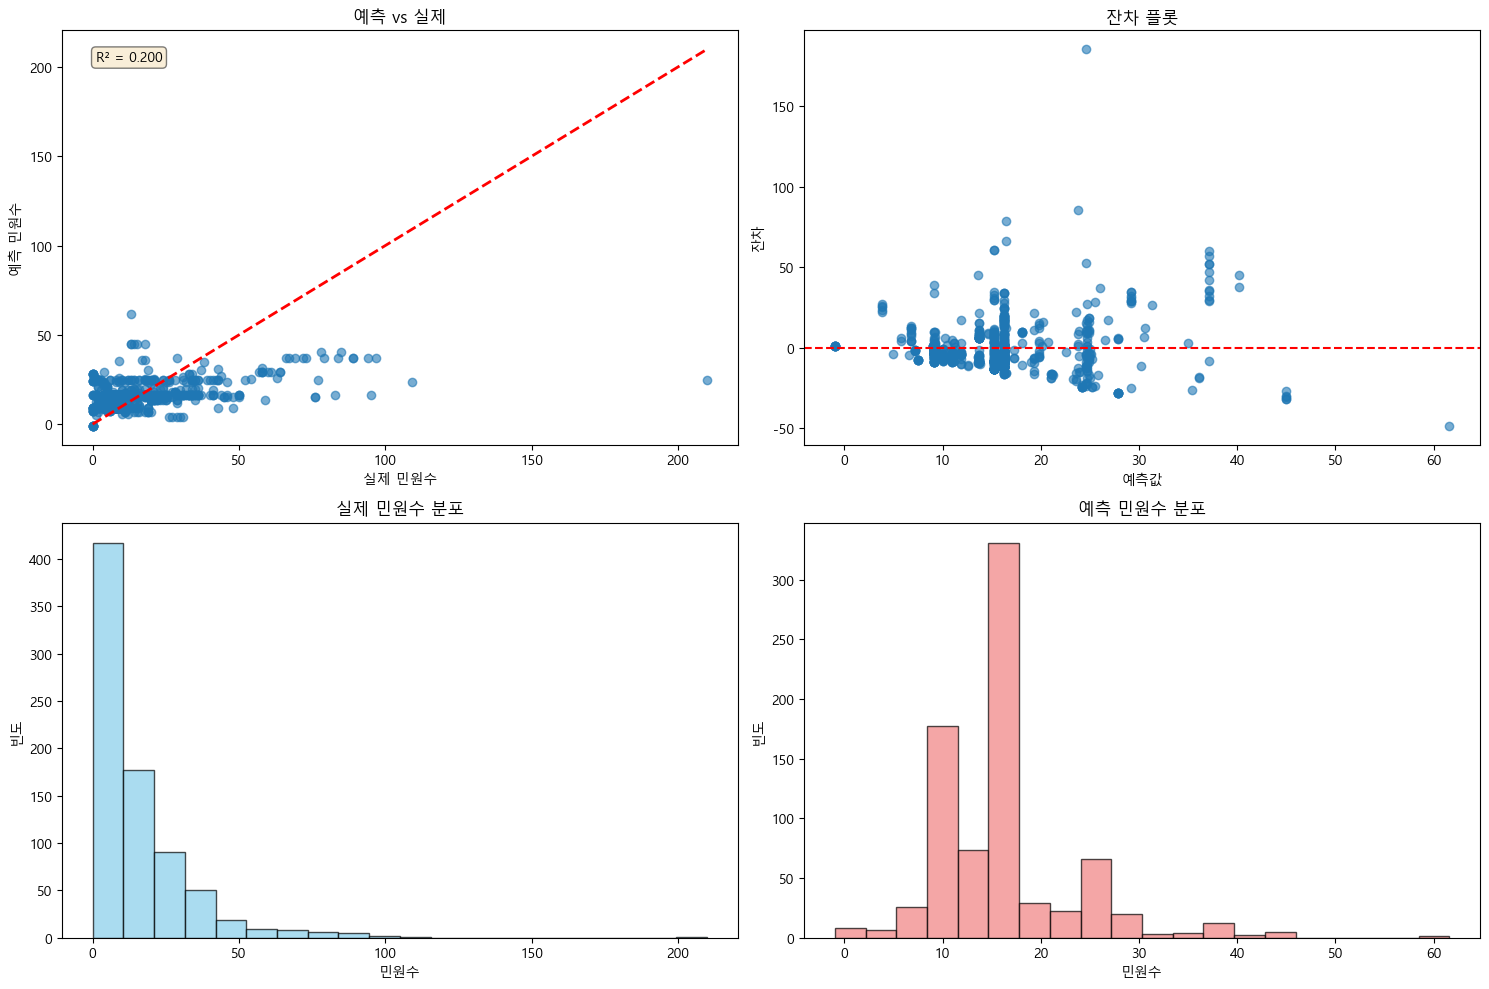

In [35]:
# 결과 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

predictor.plot_results(results)


=== 회귀 계수 분석 ===
절댓값 기준 상위 10개 특성:
    feature   coefficient
14   평균운영시간  3.531763e+14
2   토요일운영시간 -2.427781e+14
3   공휴일운영시간 -1.575318e+14
1    평일운영시간 -1.086210e+14
4      평일시작  1.206463e+01
8     공휴일시작 -1.046554e+01
6     토요일시작  8.136179e+00
5      평일종료  5.197806e+00
7     토요일종료  2.728231e+00
9     공휴일종료 -2.479950e+00


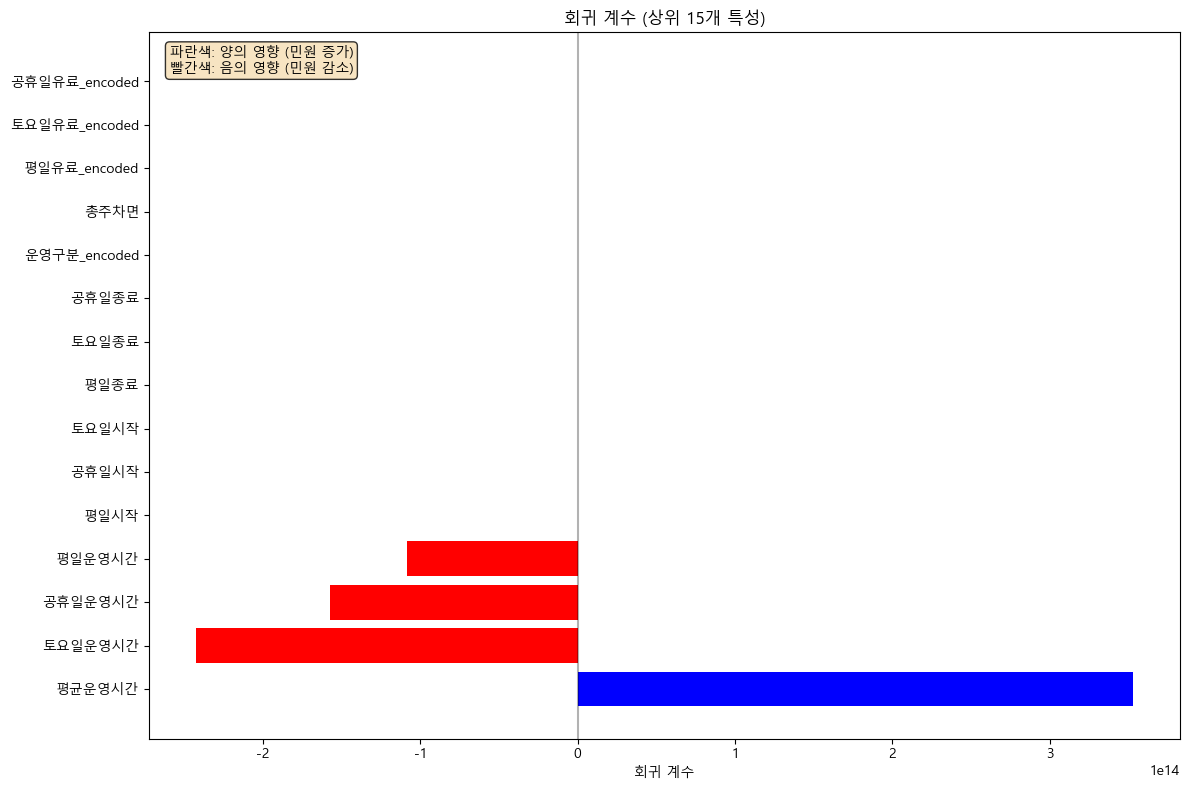

In [36]:
# 회귀 계수 분석
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

coefficients = predictor.analyze_coefficients()